In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import cftime
import os
from datetime import datetime
from src.Enumerations import Season, Experiments
import matplotlib.pyplot as plt
import numpy as np
from cdo import Cdo
import glob
from src.plot_funcs import plot_contourf_rotated_grid


/work/aa0238/a271093/Conda/MOAAP_env/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [ ]:
exp=Experiments.ICON_CNRM_SSP.value



path_in = exp.path_IVT
year_start = exp.year_start
year_end = exp.year_end -5

year = year_start
cdo = Cdo()

while year <= year_end:

    cdo.daymean(input= f" -expr,'IVTabs=sqrt(IVTv^2+IVTu^2)' -daymean -merge {path_in}IVTu/IVTu_{year}010100-{year}123123_remapped_3x.nc {path_in}IVTv/IVTv_{year}010100-{year}123123_remapped_3x.nc ",
        output = f"{exp.scratch_path}daymean/dummy/{year}_dummy.nc")

    year+=1

paths = sorted(glob.glob(f"{exp.scratch_path}daymean/dummy/*"))
cdo.mergetime(input = ' '.join(paths),
              output = f"{exp.scratch_path}daymean/ssp/IVTabs_CNRM_ssp.nc"
             )

files_IVTu =  sorted(glob.glob(f"{exp.path_IVT}IVTu/*"))

cdo.daymean(input=f" -mergetime "+' '.join(files_IVTu),
            output = f"{exp.scratch_path}daymean/ssp/IVTu_CNRM_ssp.nc"
            )

files_IVTv =  sorted(glob.glob(f"{exp.path_IVT}IVTv/*"))
cdo.daymean(input=f" -mergetime "+' '.join(files_IVTv),
            output = f"{exp.scratch_path}daymean/ssp/IVTv_CNRM_ssp.nc"
            )

files = glob.glob(f"{exp.scratch_path}daymean/dummy/*")
for f in files:
    os.remove(f)



In [46]:
exp =Experiments.ICON_CNRM_CONTROL.value
path_in = exp.path
year_start = exp.year_start
year_end = exp.year_end

year = year_start
cdo = Cdo()
while year <= year_end:

    cdo.daymean(input= f" -expr,'IVTabs=sqrt(IVTv^2+IVTu^2)'  -merge {path_in}IVTu/IVTu_{year}010100-{year}123123_remapped_3x.nc {path_in}IVTv/IVTv_{year}010100-{year}123123_remapped_3x.nc ",
        output = f"{exp.scratch_path}daymean/dummy/{year}_dummy.nc")

    year+=1

paths = sorted(glob.glob(f"{exp.scratch_path}daymean/dummy/*"))
cdo.mergetime(input = ' '.join(paths),
              output = f"{exp.scratch_path}daymean/control/IVTabs_CNRM_control.nc"
             )

files_IVTu =  sorted(glob.glob(f"{exp.path}IVTu/*"))

cdo.daymean(input=f" -mergetime "+' '.join(files_IVTu),
            output = f"{exp.scratch_path}daymean/control/IVTu_CNRM_control.nc"
            )

files_IVTv =  sorted(glob.glob(f"{exp.path}IVTv/*"))
cdo.daymean(input=f" -mergetime "+' '.join(files_IVTv),
            output = f"{exp.scratch_path}daymean/control/IVTv_CNRM_control.nc"
            )

files = glob.glob(f"{exp.scratch_path}daymean/dummy/*")
for f in files:
    os.remove(f)

In [4]:
exp=Experiments.ICON_CNRM_SSP.value


abs_ssp=xr.load_dataset(f"{exp.scratch_path}daymean/ssp/IVTabs_CNRM_ssp.nc")
abs_ctrl = xr.load_dataset( f"{exp.scratch_path}daymean/control/IVTabs_CNRM_control.nc")

u_ctrl = xr.load_dataset(f"{exp.scratch_path}daymean/control/IVTu_CNRM_control.nc")
u_ssp = xr.load_dataset(f"{exp.scratch_path}daymean/ssp/IVTu_CNRM_ssp.nc")

v_ctrl = xr.load_dataset(f"{exp.scratch_path}daymean/control/IVTv_CNRM_control.nc")
v_ssp =xr.load_dataset(f"{exp.scratch_path}daymean/ssp/IVTv_CNRM_ssp.nc")

# Compare CNRM control IVTabs with CNRM ssp (2060-2094)
- mean diffences and change in 85 quantile

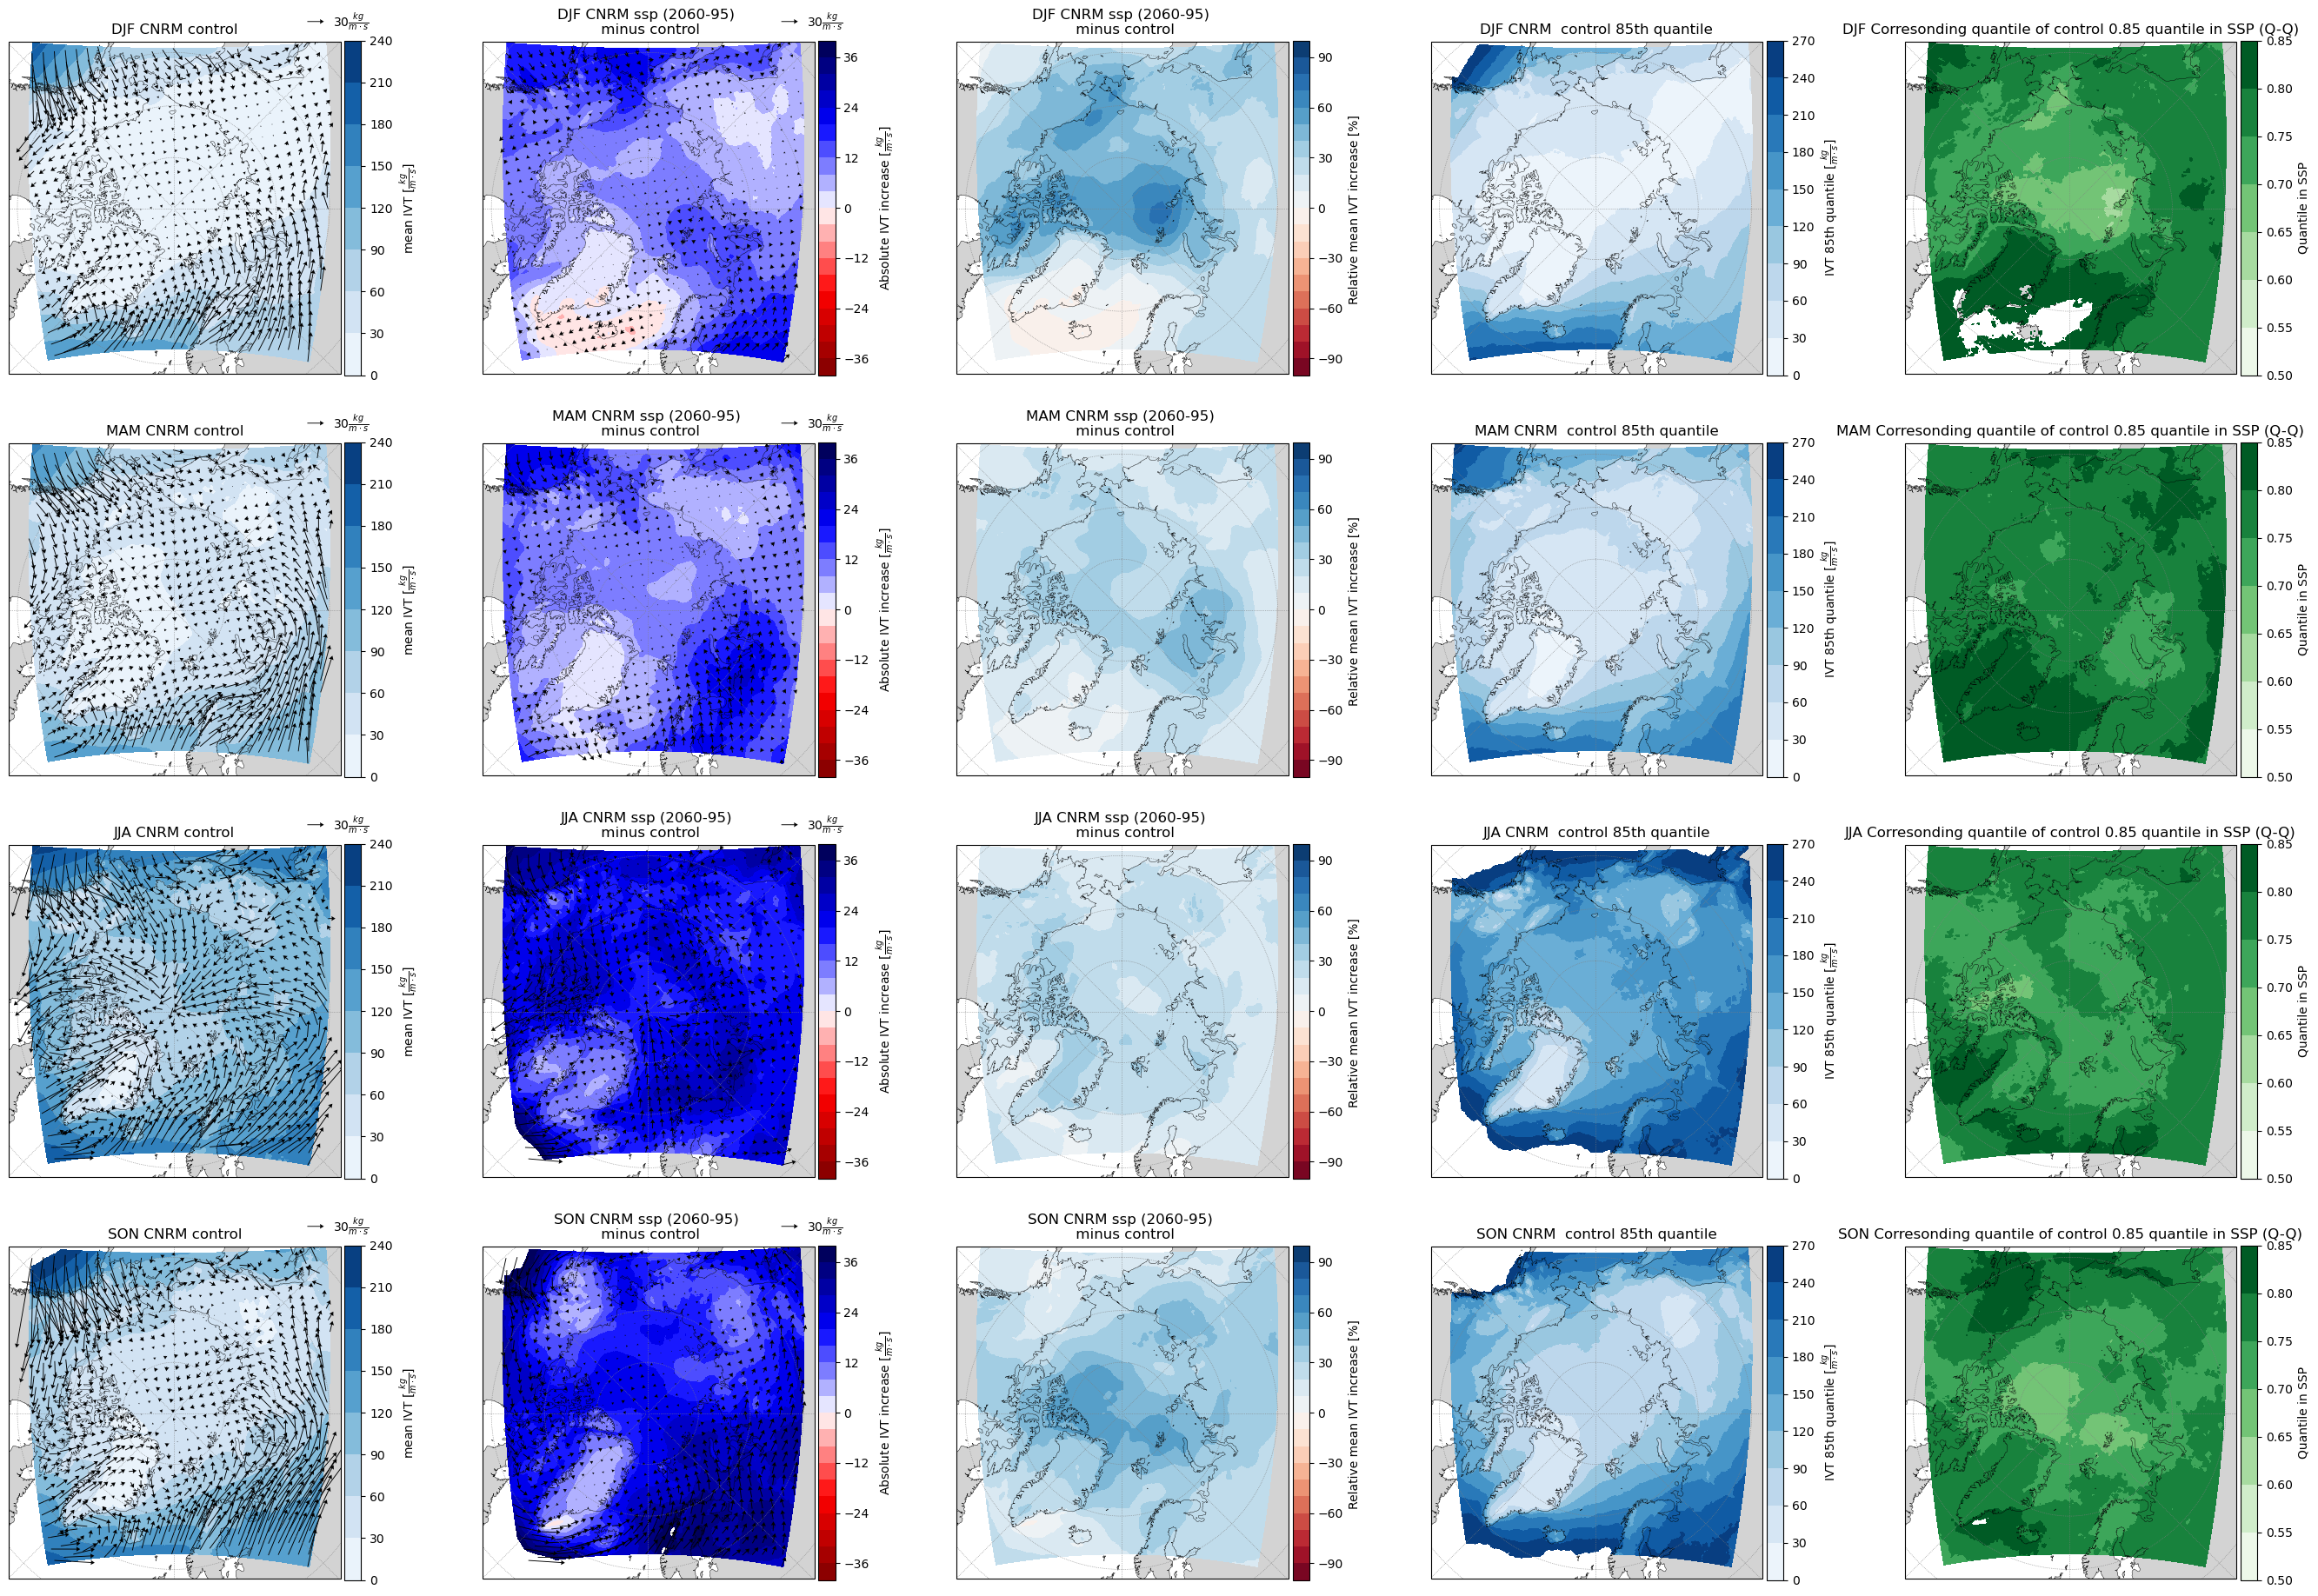

In [5]:
fig = plt.figure(figsize=(34,23))
for  season_, i in zip(Season,[0,5,10,15]):
    
    ssp = abs_ssp.sel(time=abs_ssp.time.dt.month.isin(season_.value))
    #ctrl = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2015,2025)))

    ssp = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2060,2094)))
    ctrl = abs_ctrl.sel(time=abs_ctrl.time.dt.month.isin(season_.value))
    #ctrl = ctrl.sel(time=ctrl.time.dt.year.isin(np.arange(2000,2012)))

    
    ssp_v = v_ssp.sel(time=v_ssp.time.dt.month.isin(season_.value))
    ssp_v = ssp_v.sel(time=ssp_v.time.dt.year.isin(np.arange(2060,2094)))
    ctrl_v = v_ctrl.sel(time=v_ctrl.time.dt.month.isin(season_.value))

    ssp_u = u_ssp.sel(time=u_ssp.time.dt.month.isin(season_.value))
    ssp_u = ssp_u.sel(time=ssp_u.time.dt.year.isin(np.arange(2060,2094)))
    ctrl_u = u_ctrl.sel(time=u_ctrl.time.dt.month.isin(season_.value))

   

    mean = ctrl.IVTabs.mean(dim="time").values
    mean_u = ctrl_u.IVTu.mean(dim="time").values
    mean_v = ctrl_v.IVTv.mean(dim="time").values

    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean,
                                index =i,
                               fig = fig,
                               subplts=(4,5),
                               title=f'{season_.name} CNRM control',
                              levels =np.arange(0,260,30),
                              cbar_label= "mean IVT "+r"$ [\frac{kg}{m \cdot s}]$",
                              cmap="Blues",
                              reglat = ssp.lat.values,
                               reglon = ssp.lon.values,
                              quiver_dat = [mean_u,mean_v],
                              quiver_thinning = 50,
                               quiver_scale = 600,
                              quiver_unit_scale = 30)


    mean_diff = (ssp.IVTabs.mean(dim="time").values-ctrl.IVTabs.mean(dim="time").values)
    u_diff = (ssp_u.IVTu.mean(dim="time").values-ctrl_u.IVTu.mean(dim="time").values)
    v_diff = (ssp_v.IVTv.mean(dim="time").values-ctrl_v.IVTv.mean(dim="time").values)


    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean_diff,
                                index =i+1,
                               fig = fig,
                               subplts=(4,5),
                               title=f'{season_.name} CNRM ssp (2060-95) \n minus control',
                              levels =np.arange(-40,41,4),
                              cbar_label= "Absolute IVT increase "+r"$ [\frac{kg}{m \cdot s}]$",
                              cmap="seismic_r",
                              reglat = ssp.lat.values,
                               reglon = ssp.lon.values,
                              quiver_dat = [u_diff,v_diff],
                              quiver_thinning = 50,
                               quiver_scale = 600,
                              quiver_unit_scale = 30)

    mean_diff = ((ssp.IVTabs.mean(dim="time").values-ctrl.IVTabs.mean(dim="time").values)/ctrl.IVTabs.mean(dim="time").values)*100
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean_diff,
                                index =i+2,
                               fig = fig,
                               subplts=(4,5),
                               title=f'{season_.name} CNRM ssp (2060-95) \n minus control',
                              levels =np.arange(-100,101,10),
                              cbar_label= "Relative mean IVT increase [%] ",
                              cmap="RdBu",
                            )

    #mean_diff = ((ssp.IVTabs.mean(dim="time").values-ctrl.IVTabs.mean(dim="time").values)/ctrl.IVTabs.mean(dim="time").values)*100
    #u_diff = (ssp_u.IVTu.mean(dim="time").values-ctrl_u.IVTu.mean(dim="time").values)
    #v_diff = (ssp_v.IVTv.mean(dim="time").values-ctrl_v.IVTv.mean(dim="time").values)

    q85 = ctrl.IVTabs.quantile(0.85,dim="time")
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               q85,
                                index =i+3,
                               fig = fig,
                               subplts=(4,5),
                               title=f'{season_.name} CNRM  control 85th quantile',
                              levels =np.arange(0,300,30),
                              cbar_label= "IVT 85th quantile "+r"$ [\frac{kg}{m \cdot s}]$",
                              cmap="Blues")
    

    ssp_q85 = (ssp.IVTabs<q85).sum(dim="time")/ssp.IVTabs.count(dim="time")
    #ssp_q85 = ssp.IVTabs.quantile(0.5,dim="time")-ctrl.IVTabs.quantile(0.5,dim="time")
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               ssp_q85,
                                index =i+4,
                               fig = fig,
                               subplts=(4,5),
                               title=f'{season_.name} Corresonding quantile of control 0.85 quantile in SSP (Q-Q)',
                              levels =np.arange(0.5,0.9,0.05),
                              cbar_label= "Quantile in SSP",
                              cmap="Greens")

   

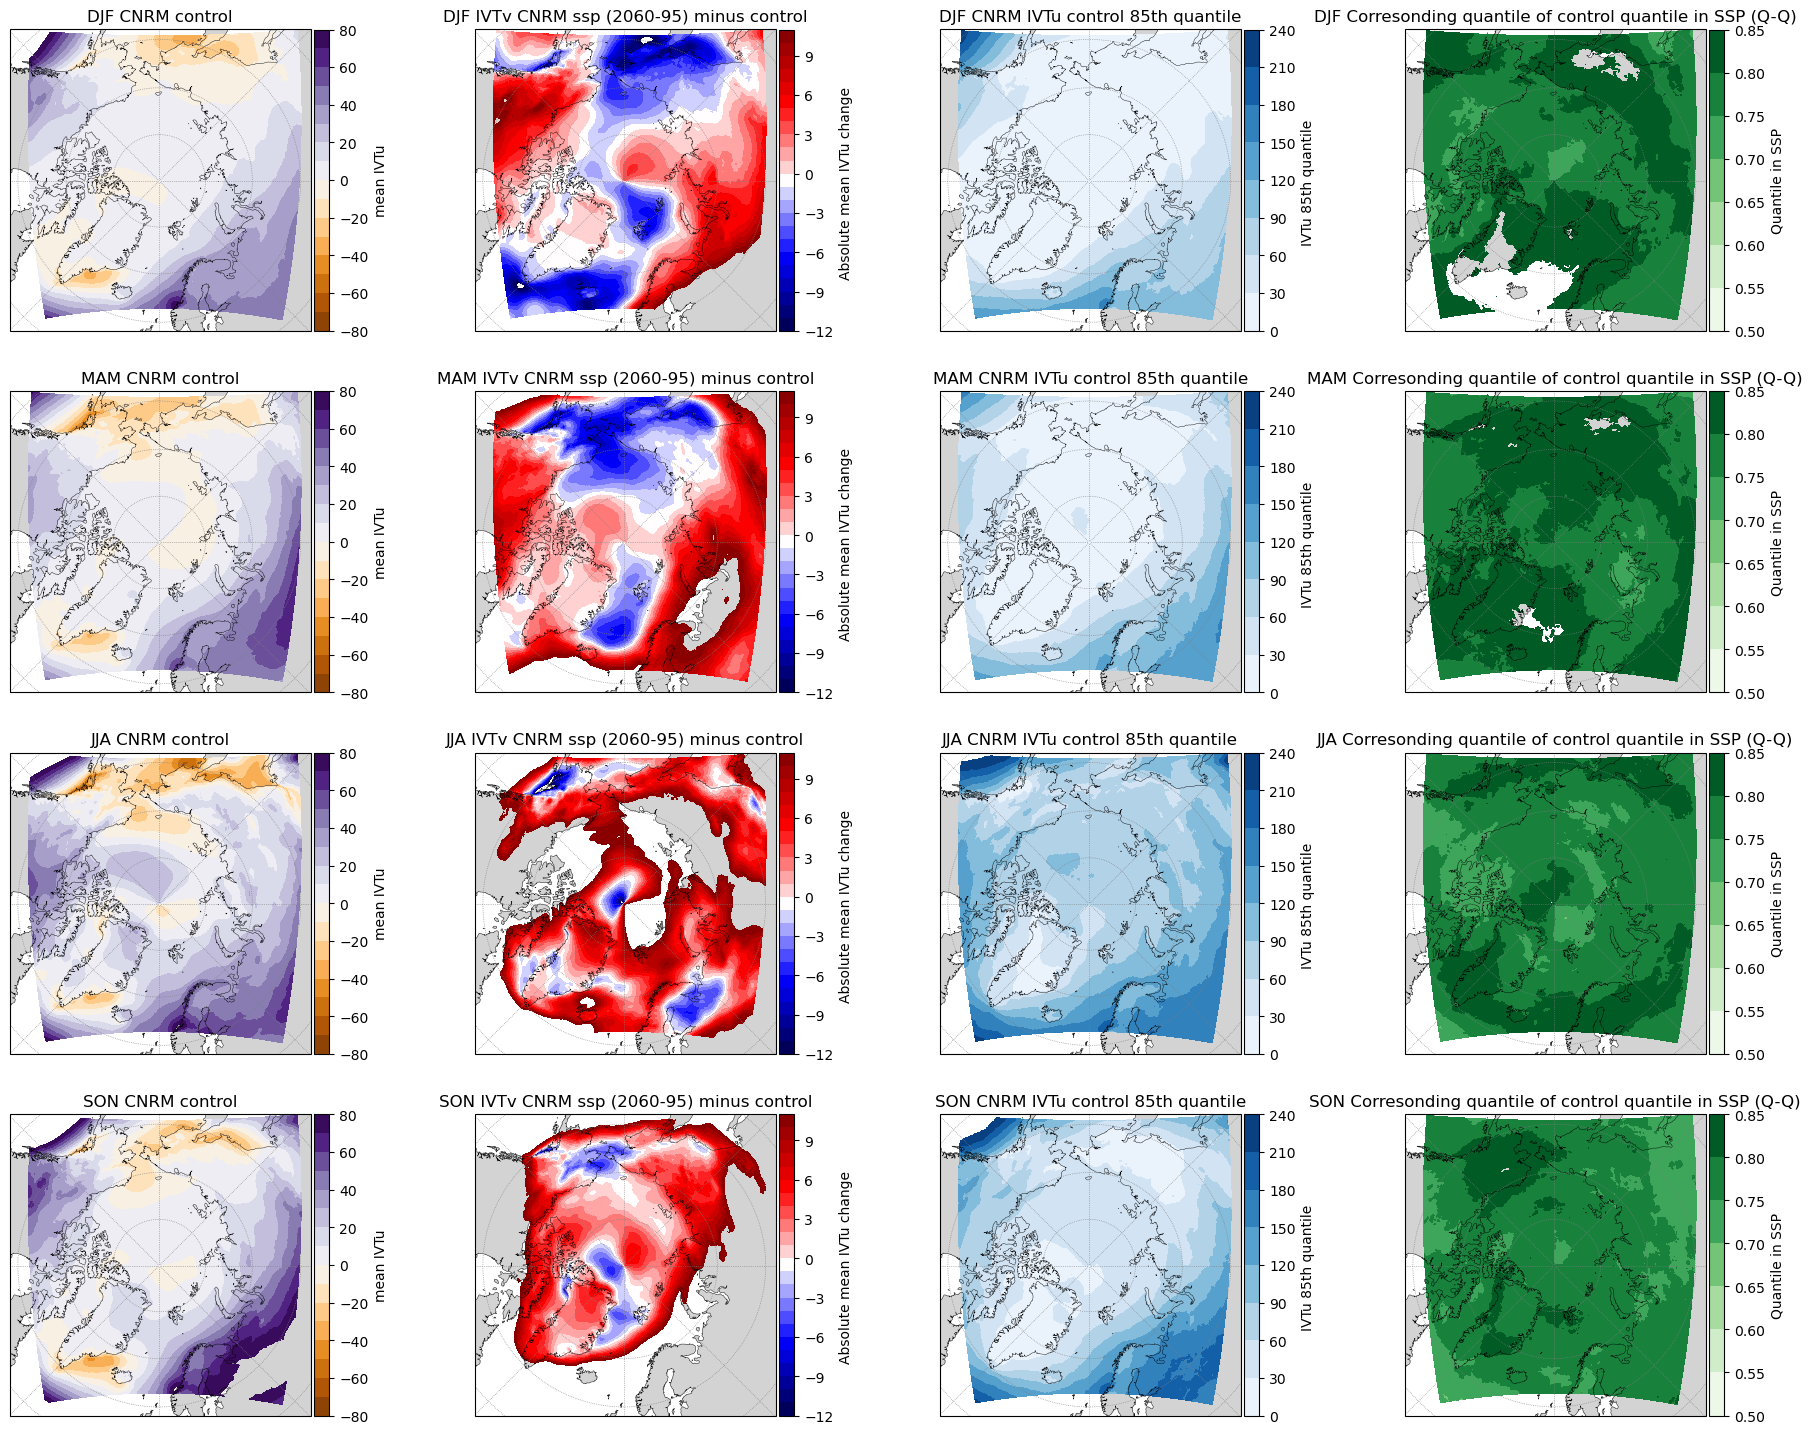

In [ ]:
fig = plt.figure(figsize=(23,18))
for  season_, i in zip(Season,[0,4,8,12]):
    
    ssp = u_ssp.sel(time=u_ssp.time.dt.month.isin(season_.value))
    #ctrl = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2015,2025)))

    ssp = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2060,2094)))
    ctrl = u_ctrl.sel(time=u_ctrl.time.dt.month.isin(season_.value))
    #ctrl = ctrl.sel(time=ctrl.time.dt.year.isin(np.arange(2000,2012)))


    mean = ctrl.IVTu.mean(dim="time").values
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean,
                                index =i,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} CNRM control',
                              levels =np.arange(-80,81,10),
                              cbar_label= "mean IVTu",
                              cmap="PuOr")

    mean_diff = (ssp.IVTu.mean(dim="time").values-ctrl.IVTu.mean(dim="time").values)
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean_diff,
                                index =i+1,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} IVTu CNRM ssp (2060-95) minus control',
                              levels =np.arange(-20,20,2),
                              cbar_label= "Absolute mean IVTu change ",
                              cmap="seismic")

    q85 = ctrl.IVTu.quantile(0.85,dim="time")
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               q85,
                                index =i+2,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} CNRM IVTu control 85th quantile',
                              levels =np.arange(0,260,30),
                              cbar_label= "IVTu 85th quantile ",
                              cmap="Blues")
    

    ssp_q85 = (ssp.IVTu<q85).sum(dim="time")/ssp.IVTu.count(dim="time")
    #ssp_q85 = ssp.IVTabs.quantile(0.5,dim="time")-ctrl.IVTabs.quantile(0.5,dim="time")
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               ssp_q85,
                                index =i+3,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} Corresonding quantile of control quantile in SSP (Q-Q)',
                              levels =np.arange(0.5,0.9,0.05),
                              cbar_label= "Quantile in SSP",
                              cmap="Greens")
    

# Compare CNRM control IVTv with CNRM ssp (2060-2094)


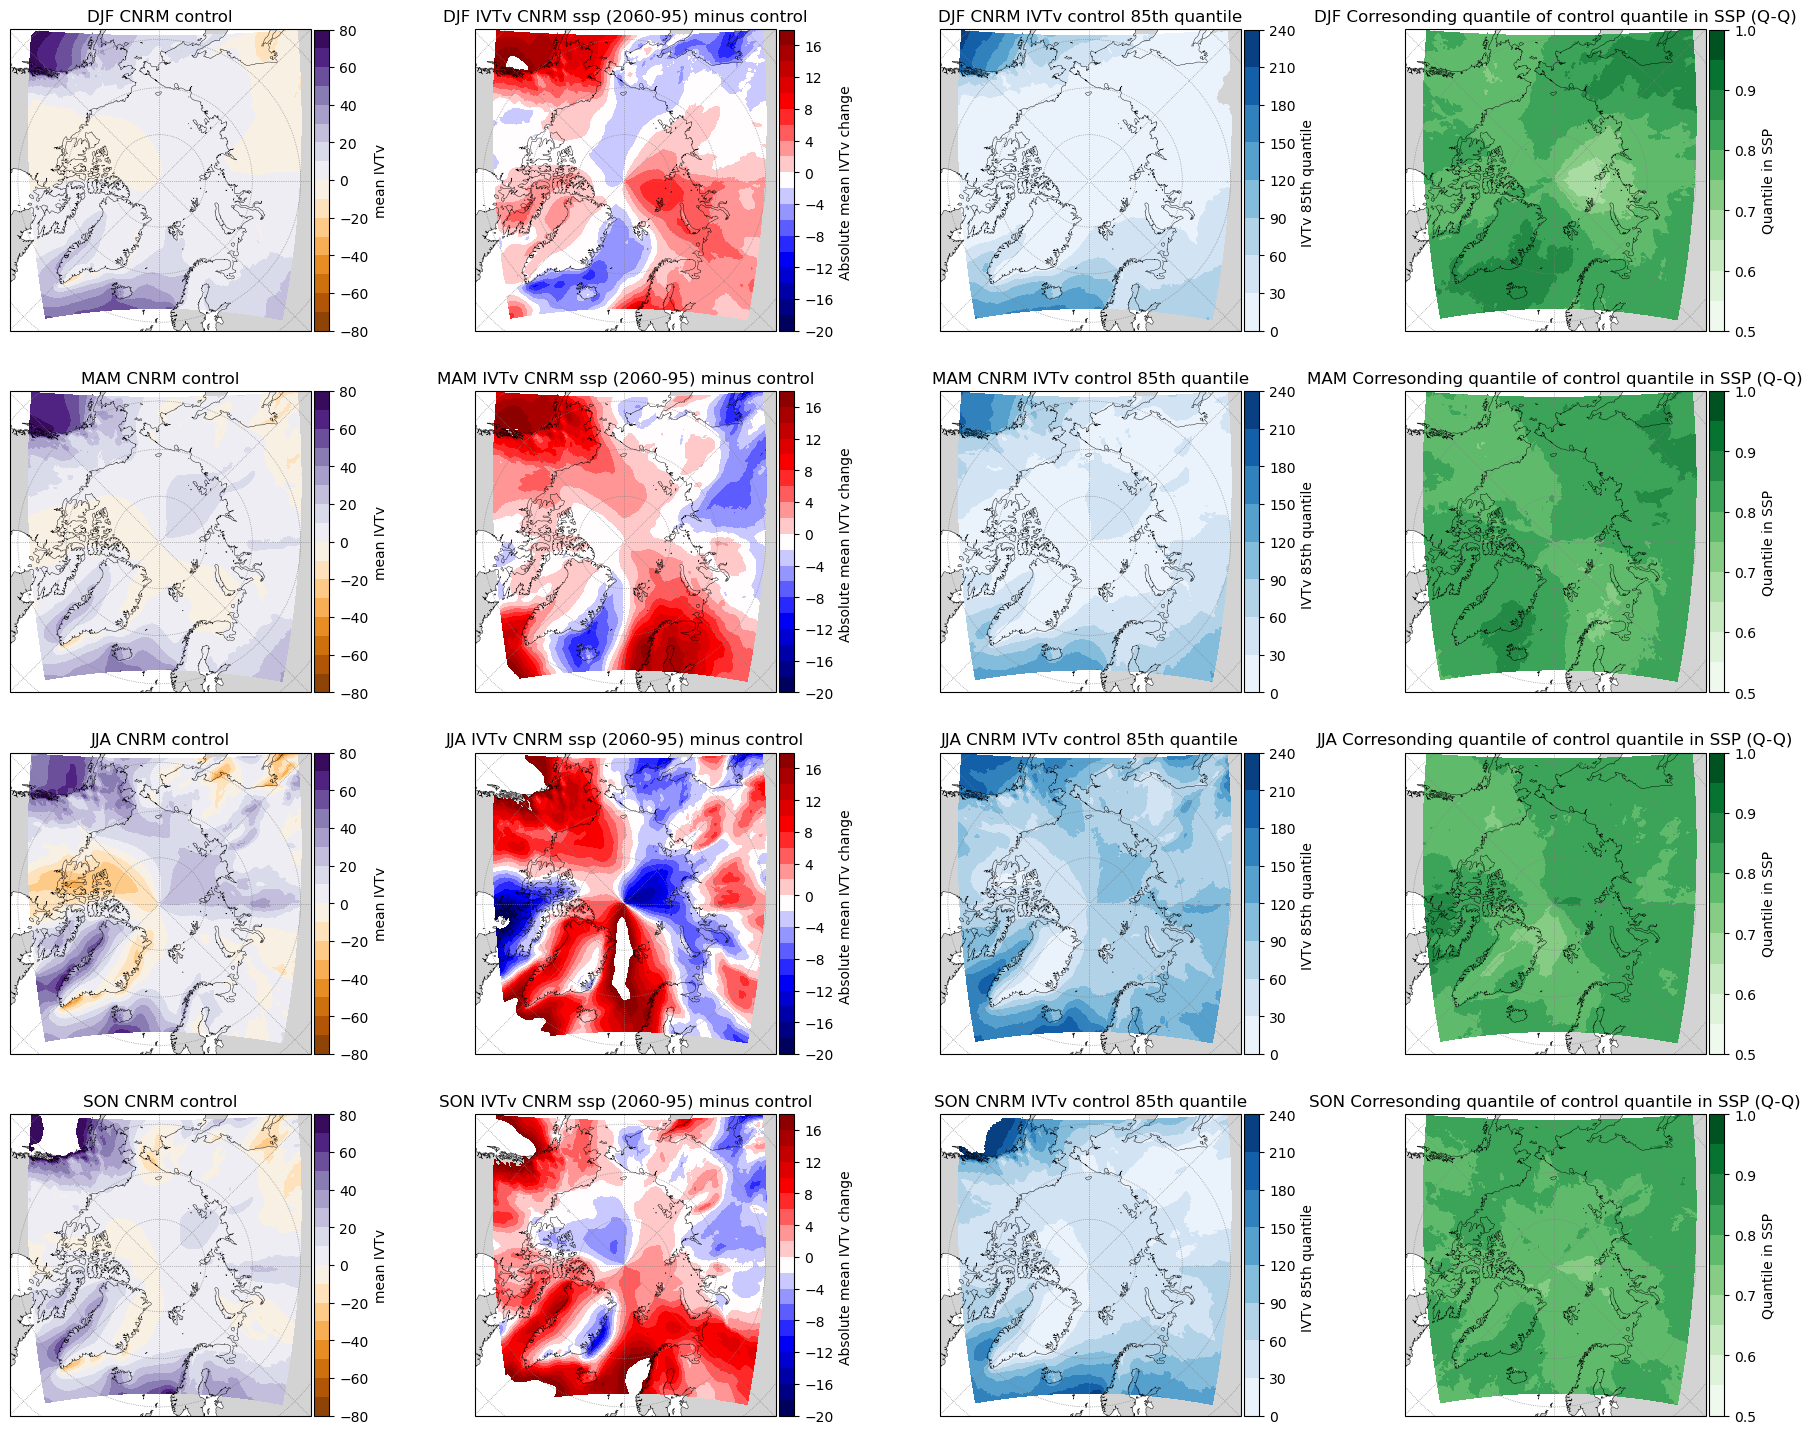

In [5]:
fig = plt.figure(figsize=(23,18))
for  season_, i in zip(Season,[0,4,8,12]):
    
    ssp = v_ssp.sel(time=v_ssp.time.dt.month.isin(season_.value))
    #ctrl = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2015,2030)))

    ssp = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2060,2094)))
    ctrl = v_ctrl.sel(time=v_ctrl.time.dt.month.isin(season_.value))
    #ctrl = ctrl.sel(time=ctrl.time.dt.year.isin(np.arange(2000,2012)))


    mean = ctrl.IVTv.mean(dim="time").values
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean,
                                index =i,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} CNRM control',
                              levels =np.arange(-80,81,10),
                              cbar_label= "mean IVTv",
                              cmap="PuOr")

    mean_diff = (ssp.IVTv.mean(dim="time").values-ctrl.IVTv.mean(dim="time").values)
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               mean_diff,
                                index =i+1,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} IVTv CNRM ssp (2060-95) minus control',
                              levels =np.arange(-20,20,2),
                              cbar_label= "Absolute mean IVTv change ",
                              cmap="seismic")


    q85 = ctrl.IVTv.quantile(0.85,dim="time")
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               q85,
                                index =i+2,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} CNRM IVTv control 85th quantile',
                              levels =np.arange(0,260,30),
                              cbar_label= "IVTv 85th quantile ",
                              cmap="Blues")
    

    ssp_q85 = (ssp.IVTv<q85).sum(dim="time")/ssp.IVTv.count(dim="time")
    #ssp_q85 = ssp.IVTabs.quantile(0.5,dim="time")-ctrl.IVTabs.quantile(0.5,dim="time")
    plot_contourf_rotated_grid(ssp.rlon.values,
                               ssp.rlat.values,
                               ssp_q85,
                                index =i+3,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name} Corresonding quantile of control quantile in SSP (Q-Q)',
                              levels =np.arange(0.5,1.001,0.05),
                              cbar_label= "Quantile in SSP",
                              cmap="Greens")

In [2]:
exp=Experiments.ERA5.value



path_in = exp.path_IVT
#year_start = exp.year_start
#year_end = exp.year_end
year_start = 1998
year_end = 2022
year = year_start
cdo = Cdo()

In [7]:
while year <= year_end:

    cdo.daymean(input= f" -expr,'IVTabs=sqrt(IVTv^2+IVTu^2)' -daymean -merge {path_in}IVTu/IVTu_{year}010100-{year}123123_remapped_3x.nc {path_in}IVTv/IVTv_{year}010100-{year}123123_remapped_3x.nc ",
        output = f"{exp.scratch_path}daymean/dummy/{year}_dummy.nc")

    year+=1

paths = sorted(glob.glob(f"{exp.scratch_path}daymean/dummy/*"))
cdo.mergetime(input = ' '.join(paths),
              output = f"{exp.scratch_path}daymean/ERA5/IVTabs_ERA5.nc"
             )

files_IVTu =  sorted(glob.glob(f"{exp.path_IVT}IVTu/*"))

cdo.daymean(input=f" -mergetime "+' '.join(files_IVTu),
            output = f"{exp.scratch_path}daymean/ERA5/IVTu_ERA5.nc"
            )

files_IVTv =  sorted(glob.glob(f"{exp.path_IVT}IVTv/*"))
cdo.daymean(input=f" -mergetime "+' '.join(files_IVTv),
            output = f"{exp.scratch_path}daymean/ERA5/IVTv_ERA5.nc"
            )

files = glob.glob(f"{exp.scratch_path}daymean/dummy/*")
for f in files:
    os.remove(f)



In [3]:
exp=Experiments.ICON_ERA5.value



path_in = exp.path_IVT
year_start = exp.year_start
year_end = 2022

year = year_start
cdo = Cdo()

In [9]:
while year <= year_end:

    cdo.daymean(input= f" -expr,'IVTabs=sqrt(IVTv^2+IVTu^2)' -daymean -merge {path_in}IVTu/IVTu_{year}010100-{year}123123_remapped_3x.nc {path_in}IVTv/IVTv_{year}010100-{year}123123_remapped_3x.nc ",
        output = f"{exp.scratch_path}daymean/dummy/{year}_dummy.nc")

    year+=1

paths = sorted(glob.glob(f"{exp.scratch_path}daymean/dummy/*"))
cdo.mergetime(input = ' '.join(paths),
              output = f"{exp.scratch_path}daymean/ICON_ERA5/IVTabs_ICON_ERA5.nc"
             )

files_IVTu =  sorted(glob.glob(f"{exp.path_IVT}IVTu/*"))

cdo.daymean(input=f" -mergetime "+' '.join(files_IVTu),
            output = f"{exp.scratch_path}daymean/ICON_ERA5/IVTu_ICON_ERA5.nc"
            )

files_IVTv =  sorted(glob.glob(f"{exp.path_IVT}IVTv/*"))
cdo.daymean(input=f" -mergetime "+' '.join(files_IVTv),
            output = f"{exp.scratch_path}daymean/ICON_ERA5/IVTv_ICON_ERA5.nc"
            )

files = glob.glob(f"{exp.scratch_path}daymean/dummy/*")
for f in files:
    os.remove(f)



In [4]:
abs_ERA5=xr.load_dataset(f"{exp.scratch_path}daymean/ERA5/IVTabs_ERA5.nc")
u_ERA5 = xr.load_dataset(f"{exp.scratch_path}daymean/ERA5/IVTu_ERA5.nc")
v_ERA5 =xr.load_dataset(f"{exp.scratch_path}daymean/ERA5/IVTv_ERA5.nc")

abs_ICON_ERA5=xr.load_dataset(f"{exp.scratch_path}daymean/ICON_ERA5/IVTabs_ICON_ERA5.nc")
u_ICON_ERA5 = xr.load_dataset(f"{exp.scratch_path}daymean/ICON_ERA5/IVTu_ICON_ERA5.nc")
v_ICON_ERA5 =xr.load_dataset(f"{exp.scratch_path}daymean/ICON_ERA5/IVTv_ICON_ERA5.nc")

# ERA5 vs ICON-ERA5 (absolute IVT, 1998-2022)

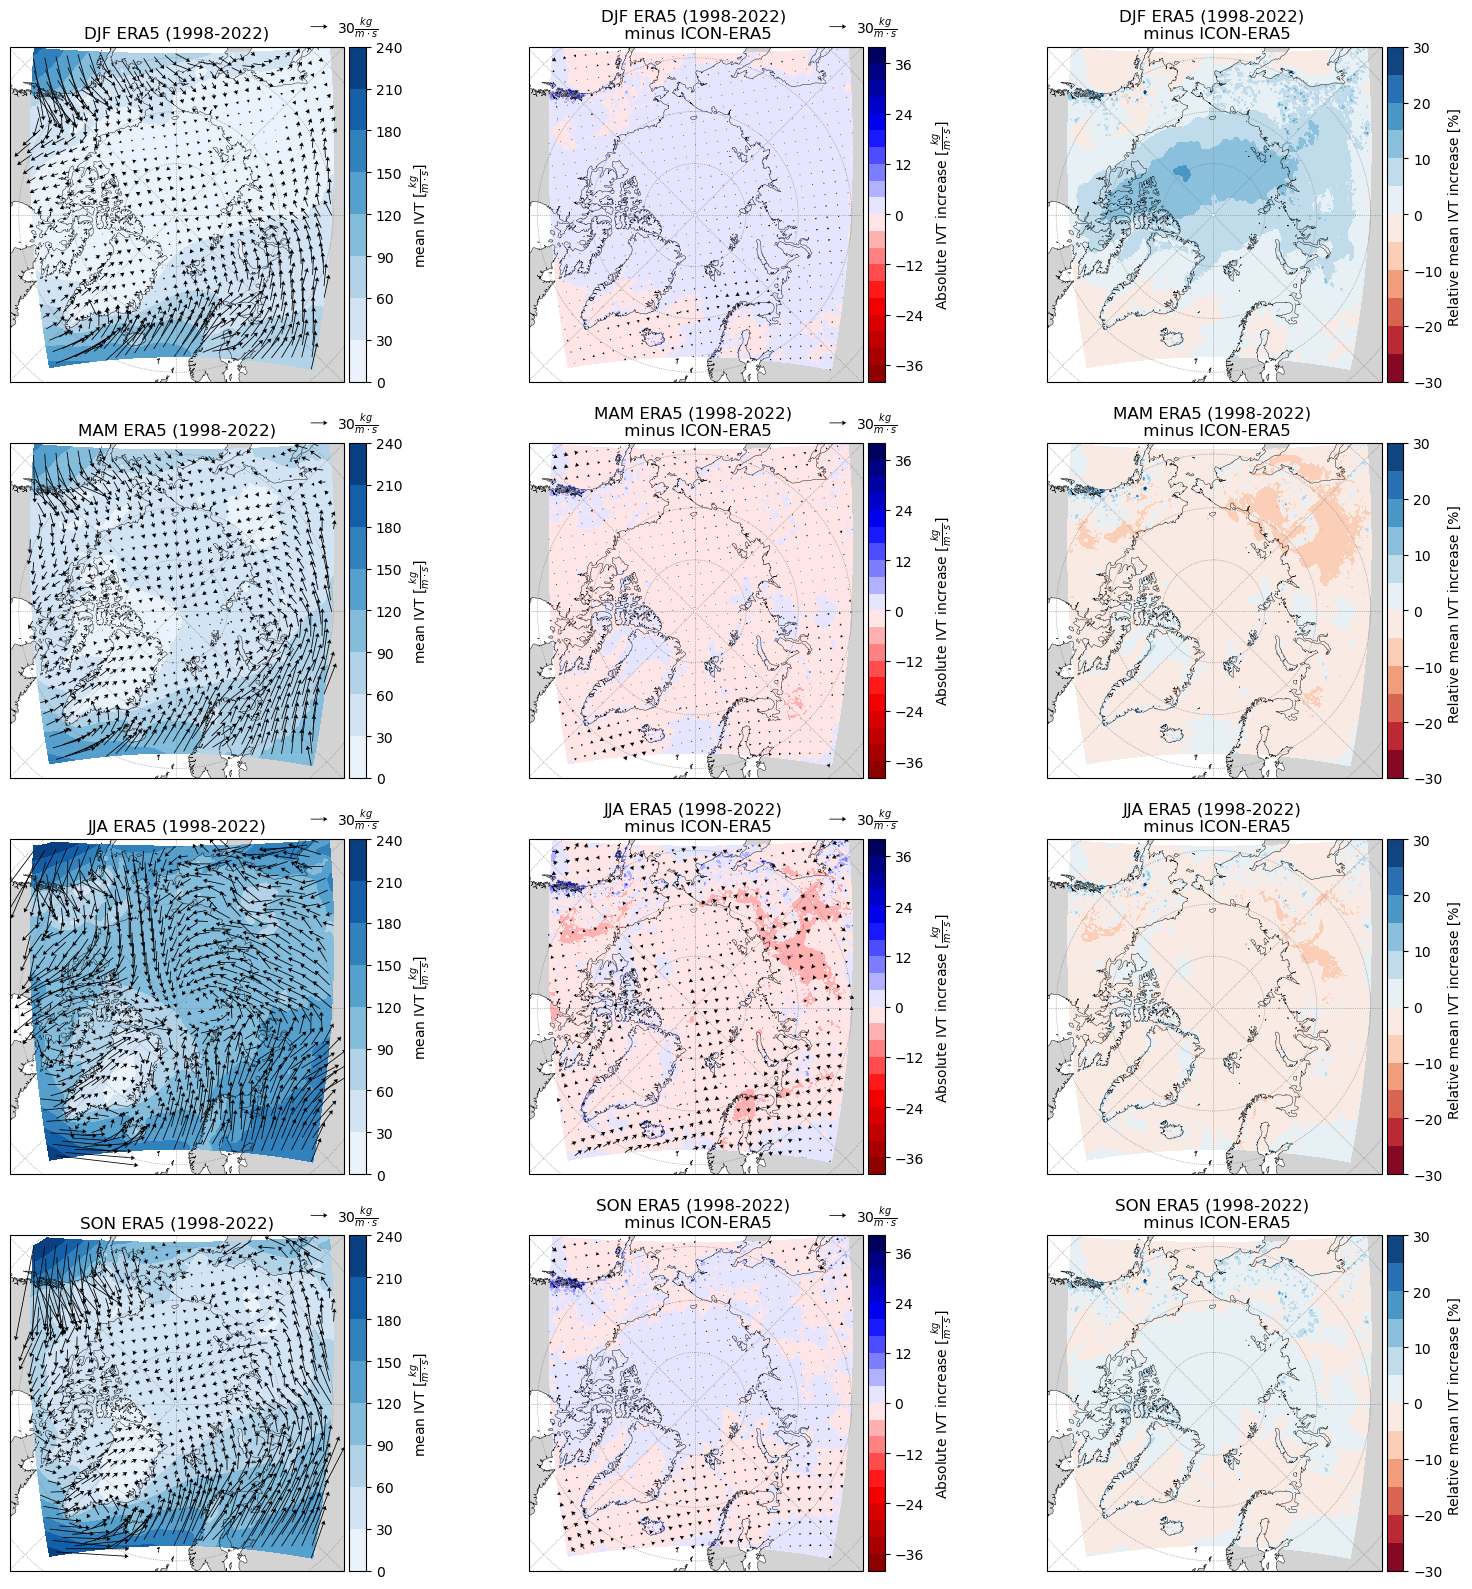

In [6]:
fig = plt.figure(figsize=(16,16))
for  season_, i in zip(Season,[0,3,6,9]):
    
    ERA5 = abs_ERA5.sel(time=abs_ERA5.time.dt.month.isin(season_.value))
    #ctrl = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2015,2025)))

    #ssp = ssp.sel(time=ssp.time.dt.year.isin(np.arange(2060,2094)))
    ICON_ERA5 = abs_ICON_ERA5.sel(time=abs_ICON_ERA5.time.dt.month.isin(season_.value))
    #ctrl = ctrl.sel(time=ctrl.time.dt.year.isin(np.arange(2000,2012)))

    
    ERA5_v = v_ERA5.sel(time=v_ERA5.time.dt.month.isin(season_.value))
    ICON_ERA5_v = v_ICON_ERA5.sel(time=v_ICON_ERA5.time.dt.month.isin(season_.value))

    ERA5_u = u_ERA5.sel(time=u_ERA5.time.dt.month.isin(season_.value))
    ICON_ERA5_u = u_ICON_ERA5.sel(time=u_ICON_ERA5.time.dt.month.isin(season_.value))

   

    mean = ERA5.IVTabs.mean(dim="time").values
    mean_u = ERA5_u.IVTu.mean(dim="time").values
    mean_v = ERA5_v.IVTv.mean(dim="time").values

    plot_contourf_rotated_grid(ERA5.rlon.values,
                               ERA5.rlat.values,
                               mean,
                                index =i,
                               fig = fig,
                               subplts=(4,3),
                               title=f'{season_.name} ERA5 (1998-2022)',
                              levels =np.arange(0,260,30),
                              cbar_label= "mean IVT "+r"$ [\frac{kg}{m \cdot s}]$",
                              cmap="Blues",
                              reglat = ERA5.lat.values,
                               reglon = ERA5.lon.values,
                              quiver_dat = [mean_u,mean_v],
                              quiver_thinning = 50,
                               quiver_scale = 600,
                              quiver_unit_scale = 30)


    mean_diff = (ERA5.IVTabs.mean(dim="time").values-ICON_ERA5.IVTabs.mean(dim="time").values)
    u_diff = (ERA5_u.IVTu.mean(dim="time").values-ICON_ERA5_u.IVTu.mean(dim="time").values)
    v_diff = (ERA5_v.IVTv.mean(dim="time").values-ICON_ERA5_v.IVTv.mean(dim="time").values)


    plot_contourf_rotated_grid(ERA5.rlon.values,
                               ERA5.rlat.values,
                               mean_diff,
                                index =i+1,
                               fig = fig,
                               subplts=(4,3),
                               title=f'{season_.name} ERA5 (1998-2022) \n minus ICON-ERA5',
                              levels =np.arange(-40,41,4),
                              cbar_label= "Absolute IVT increase "+r"$ [\frac{kg}{m \cdot s}]$",
                              cmap="seismic_r",
                              reglat = ERA5.lat.values,
                               reglon = ERA5.lon.values,
                              quiver_dat = [u_diff,v_diff],
                              quiver_thinning = 50,
                               quiver_scale = 600,
                              quiver_unit_scale = 30)

    mean_diff = ((ERA5.IVTabs.mean(dim="time").values-ICON_ERA5.IVTabs.mean(dim="time").values)/ICON_ERA5.IVTabs.mean(dim="time").values)*100
    plot_contourf_rotated_grid(ERA5.rlon.values,
                               ERA5.rlat.values,
                               mean_diff,
                                index =i+2,
                               fig = fig,
                               subplts=(4,3),
                               title=f'{season_.name} ERA5 (1998-2022) \n minus ICON-ERA5',
                              levels =np.arange(-30,31,5),
                              cbar_label= "Relative mean IVT increase [%] ",
                              cmap="RdBu",
                            )

plt.tight_layout()